# 객체 추적과 모션 벡터  
  
1. 배경 차분(Background Subtraction: BS)  
• 등록된 배경 모델과 현재 입력 프레임과의 차영상을 이용하여 전경 객체를 검출  
• 움직이는 전경 객체 검출을 위한 기본적인 방법  
  
  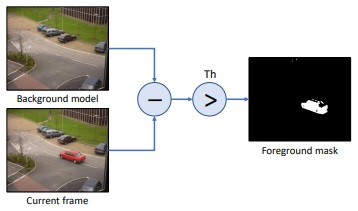  
  
정적 배경 차분  
• 정적 배경을 이용한 전경 객체 검출 실행 결과  
• 배경 영상과 현재 프레임에 대해 각각 가우시안 필터링을 수행하여 잡음 제거  

In [3]:
import sys
import numpy as np
import cv2

# 비디오 파일 열기
cap = cv2.VideoCapture('img/PETS2000.avi')

if not cap.isOpened():
    print('Video open failed!')
    sys.exit()

# frame 1개를 읽어서 배경 영상 등록
ret, back = cap.read()

if not ret:
    print('Background image registration failed!')
    sys.exit()

back = cv2.cvtColor(back, cv2.COLOR_BGR2GRAY)
back = cv2.GaussianBlur(back, (0, 0), 1.0)  # 가우시안으로 노이즈값을 제거해준다.

# 비디오 매 프레임 처리
while True:
    ret, frame = cap.read()

    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (0, 0), 1.0)

    # 차영상 구하기 & 이진화
    diff = cv2.absdiff(gray, back)
    _, diff = cv2.threshold(diff, 30, 255, cv2.THRESH_BINARY)

    cv2.imshow('frame', frame)
    cv2.imshow('diff', diff)

    if cv2.waitKey(30) == 27:
        break

cap.release()
cv2.destroyAllWindows()


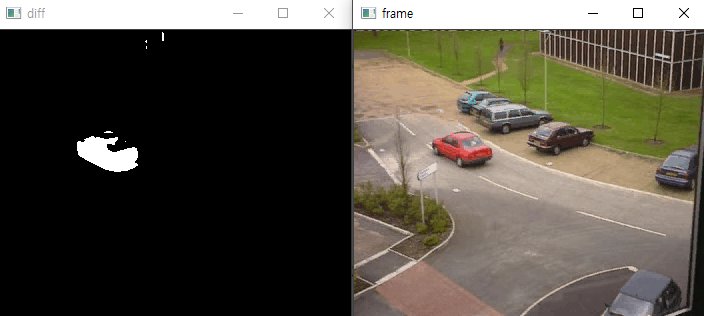

In [4]:
import sys
import numpy as np
import cv2


# 비디오 파일 열기
cap = cv2.VideoCapture('img/PETS2000.avi')

if not cap.isOpened():
    print('Video open failed!')
    sys.exit()

# 배경 영상 등록
ret, back = cap.read()

if not ret:
    print('Background image registration failed!')
    sys.exit()

back = cv2.cvtColor(back, cv2.COLOR_BGR2GRAY)
back = cv2.GaussianBlur(back, (0, 0), 1.0)

# 비디오 매 프레임 처리
while True:
    ret, frame = cap.read()

    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (0, 0), 1.0)

    # 차영상 구하기 & 이진화
    diff = cv2.absdiff(gray, back)  # 절대값으로 차이를 계산한다.
    _, diff = cv2.threshold(diff, 30, 255, cv2.THRESH_BINARY)  # threshold 묶음

    # 레이블링을 이용하여 바운딩 박스 표시
    cnt, _, stats, _ = cv2.connectedComponentsWithStats(diff)  # 갯수와 상태를 connectedComponentsWithStats로 불러옴

    for i in range(1, cnt):
        x, y, w, h, s = stats[i]

        if s < 100:
            continue

        cv2.rectangle(frame, (x, y, w, h), (0, 0, 255), 2)  # 원본 박스에 색을 칠한다.

    cv2.imshow('frame', frame)
    cv2.imshow('diff', diff)

    if cv2.waitKey(30) == 27:
        break

cap.release()
cv2.destroyAllWindows()


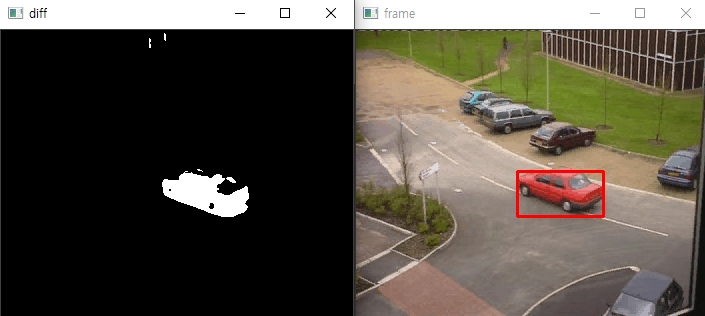

이동 평균 배경차분  
▪ 정적 배경 모델 사용 시 문제점  
• 미리 등록된 기준 영상이 실제 배경과 크게 달라질 경우 오동작  
(예)그림자 등의 영향으로 인한 조도 변경, 새로운 객체가 화면에 고정될 경우  
  
평균 연산에 의한 배경 영상 생성  
• 움직이는 객체가 존재하는 수백 장의 입력 영상으로부터 평균 영상을 구하면? => 수백 장의 이전 프레임을 버퍼에 저장하려면 대용량 메모리가 필요  
  
이동 평균(Moving average)이란?  
• 수백 장의 영상을 저장하는 대신 매 프레임이 들어올 때마다 평균 영상을 갱신  
• 대용량 버퍼 메모리가 필요하지 않음  
  
이동 평균 계산을 위한 가중치 누적 함수  
cv2.accumulateWeighted(src, dst, alpha, mask=None) -> dst  

src: 입력 영상. 1 또는 3채널. 8비트 또는 32비트 실수형  
dst: 축적 영상. 입력 영상과 동일 채널 개수.32비트 또는 64비트 실수형  
alpha: (입력 영상에 대한) 가중치  
mask: 마스크 영상  

In [6]:
import sys
import numpy as np
import cv2


# 비디오 파일 열기
cap = cv2.VideoCapture('img/PETS2000.avi')

if not cap.isOpened():
    print('Video open failed!')
    sys.exit()

# 배경 영상 등록
ret, back = cap.read()

if not ret:
    print('Background image registration failed!')
    sys.exit()

# back: uint8 배경, fback: float32 배경
back = cv2.cvtColor(back, cv2.COLOR_BGR2GRAY)
back = cv2.GaussianBlur(back, (0, 0), 1.0)
fback = back.astype(np.float32)

# 비디오 매 프레임 처리
while True:
    ret, frame = cap.read()

    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (0, 0), 1.0)

    # fback: float32, back: uint8 배경
    cv2.accumulateWeighted(gray, fback, 0.01)  # 평균을 계산한다.
    back = fback.astype(np.uint8)  # absdiff함수에서 연산하기위해서 uint형으로 맞춰준다.

    diff = cv2.absdiff(gray, back)  
    _, diff = cv2.threshold(diff, 30, 255, cv2.THRESH_BINARY)  # 객체 분리를한다.

    # 레이블링을 이용하여 바운딩 박스 표시
    cnt, _, stats, _ = cv2.connectedComponentsWithStats(diff)

    for i in range(1, cnt):
        x, y, w, h, s = stats[i]

        if s < 100:
            continue

        cv2.rectangle(frame, (x, y, w, h), (0, 0, 255), 2)

    cv2.imshow('frame', frame)
    cv2.imshow('diff', diff)
    cv2.imshow('back', back)

    if cv2.waitKey(30) == 27:
        break

cap.release()
cv2.destroyAllWindows()


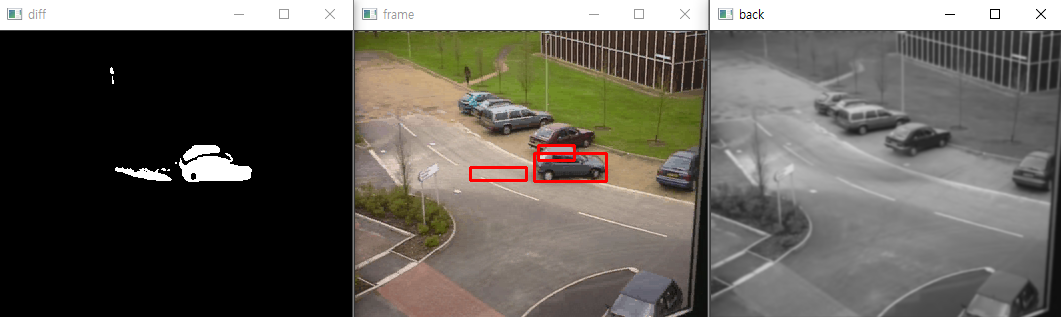

MOG 배경 모델 배경 차분  
  
MOG란?  
• Mixture of Gaussian, GMM(Gaussian Mixture Model)  
• 각 픽셀에 대해 MOG 확률 모델을 설정하여 배경과 전경을 구분  
  
다양한 배경 모델 구성 방법  
Static scene -> Single Gaussian model ->  Gaussian mixture model -> Adaptive Gaussian mixture model  
  
BackgroundSubtractorMOG2 클래스 생성 함수  
cv2.createBackgroundSubtractorMOG2(history=None, varThreshold=None, detectShadows=None) -> dst  
  
history: 히스토리 길이. 기본값은 500  
varThreshold: 픽셀과 모델 사이의 마할라노비스 거리(Mahalanobis distance) 제곱에 대한 임계값. 해당 픽셀이 배경 모델에 의해 잘 표현되는 지를 판단. 기본값은 16  
detecShadows: 그림자 검출 여부. 기본값은 True  
  
전경 객체 마스크 생성 함수  
cv2.BackgroundSubtractor.apply(image, fgmask=None, learningRate=None) -> fgmask  
  
image: (입력) 다음 비디오 프레임  
fgmask: (출력) 전경 마스크 영상. 8비트 이진 영상  
learningRate: 배경 모델 학습 속도 지정 (0~1 사이의 실수). 기본값은 -1
=>0: 배경 모델을 갱신하지 않음  
  1: 매 프레임마다 배경 모델을 새로 만듦  
  음수: 자동으로 결정됨  
  
배경 영상 반환 함수  
cv2.BackgroundSubtractor.getBackgroundImage(, backgroundImage=None) -> backgroundImage  
backgroundImage: (출력) 학습된 배경 영상  

In [7]:
import sys
import numpy as np
import cv2


# 비디오 파일 열기
cap = cv2.VideoCapture('img/PETS2000.avi')

if not cap.isOpened():
    print('Video open failed!')
    sys.exit()

# 배경 차분 알고리즘 객체 생성
bs = cv2.createBackgroundSubtractorMOG2()

# 비디오 매 프레임 처리
while True:
    ret, frame = cap.read()

    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    fgmask = bs.apply(gray)  # 전경객체로 반환한다.
    back = bs.getBackgroundImage()  # 배경을 추출한다.

    # 레이블링을 이용하여 바운딩 박스 표시
    cnt, _, stats, _ = cv2.connectedComponentsWithStats(fgmask)  # 전경 추출한의 정보로,,,

    for i in range(1, cnt):
        x, y, w, h, s = stats[i]

        if s < 80:
            continue

        cv2.rectangle(frame, (x, y, w, h), (0, 0, 255), 2)  # 원본 이미지에 박스를 씌워준다.

    cv2.imshow('frame', frame)
    cv2.imshow('back', back)
    cv2.imshow('fgmask', fgmask)

    if cv2.waitKey(20) == 27:
        break

cap.release()
cv2.destroyAllWindows()


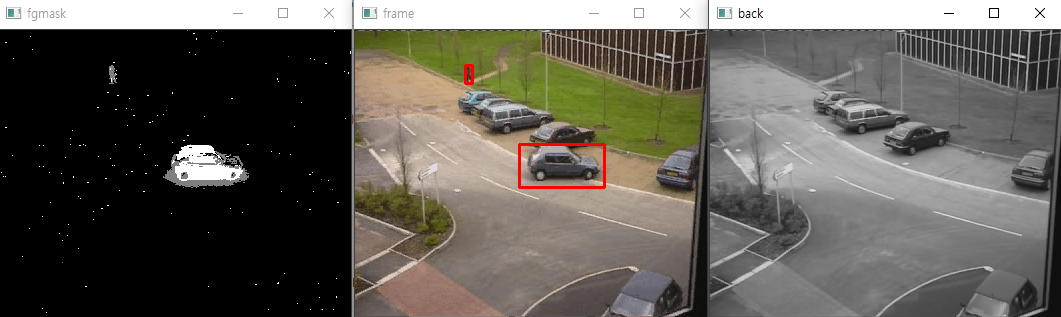

2. 추적(Tracking)  
  
Detection vs. Recognition vs. Tracking  
Detection(검출): 영상에서 찾고자 하는 대상의 위치와 크기를 알아내는 작업  
Recognition(인식): 주어진 영상이 무엇인지 판별하는 작업(classification, identification)  
Tracking(추적): 동영상에서 특정 대상의 위치 변화를 알아내는 작업  
=> Mean Shift / CamShift / Optical Flow / Trackers in OpenCV 3.x  
  
<평균 이동 알고리즘>  
평균 이동(Mean shift) 알고리즘이란?  
• 평균 이동은 해당 함수에서 샘플링 된 이산 데이터가 주어진 밀도 함수의 최대 값(모드)을 찾는 절차  
• 국지적 평균을 탐색하면서 이동  
  
평균 이동 알고리즘을 이용한 관심 영역 추적  
  
평균 이동 알고리즘을 이용한 트래킹  
cv2.meanShift(probImage, window, criteria) -> retval, window  # 객체를 추적하는 알고리즘 이다.

probImage: 관심 객체에 대한 히스토그램 역투영 영상 (확률 영상)  
window: 초기 검색 영역 윈도우 & 결과 영역 반환  
criteria: 알고리즘 종료 기준. (type, maxCount, epsilon) 튜플  
=> 예> term_crit = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1) -> 최대 10번 반복하며, 정확도가 1이하이면 (즉, 이동 크기가 1픽셀보다 작으면) 종료
retval: 알고리즘 내부 반복 횟수  
  
히스토그램 역투영
영상의 각 픽셀이 주어진 히스토그램 모델에 얼마나 일치하는지를 검사

cv2.calcBackProjection(images, channels, hist, ranges, scale, dst=None) -> dst

images: 입력 영상 리스트  
channels: 역투영 계산에 사용할 채널 번호 리스트  BGR, HSV 등등 어떤 채널로 HSV일 경우 H(0~180) S(채도) V(명도)
hist: 입력 히스토그램 (numpy.ndarray)  
ranges: 히스토그램 각 차원의 최솟값과 최댓값으로 구성된 리스트  
scale: 출력 역투영 행렬에 추가적으로 곱할 값  
dst: 출력 역투영 영상. 입력 영상과 동일 크기, cv2.CV_8U  

In [10]:
import sys
import numpy as np
import cv2


# 비디오 파일 열기
cap = cv2.VideoCapture('img/camshift.avi')

if not cap.isOpened():
    print('Video open failed!')
    sys.exit()

# 초기 사각형 영역: (x, y, w, h)
x, y, w, h = 135, 220, 100, 100
rc = (x, y, w, h)

ret, frame = cap.read()

if not ret:
    print('frame read failed!')
    sys.exit()

roi = frame[y:y+h, x:x+w]  # 관심 영역(ROI)
roi_hsv = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

# HS 히스토그램 계산
channels = [0, 1]  # 0과 1
ranges = [0, 180, 0, 256]  # 색의 범위는 0에서 180, S 채도의 색 범위는 0 에서 256
hist = cv2.calcHist([roi_hsv], channels, None, [90, 128], ranges) 

# Mean Shift 알고리즘 종료 기준
term_crit = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1)

# 비디오 매 프레임 처리
while True:
    ret, frame = cap.read()

    if not ret:
        break

    # HS 히스토그램에 대한 역투영
    frame_hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    backproj = cv2.calcBackProject([frame_hsv], channels, hist, ranges, 1)

    # Mean Shift
    _, rc = cv2.meanShift(backproj, rc, term_crit)  # 객체를 추적하는 알고리즘

    # 추적 결과 화면 출력
    cv2.rectangle(frame, rc, (0, 0, 255), 2)  # 사각형 그리기
    cv2.imshow('frame', frame)

    if cv2.waitKey(60) == 27:
        break

cap.release()
cv2.destroyAllWindows()

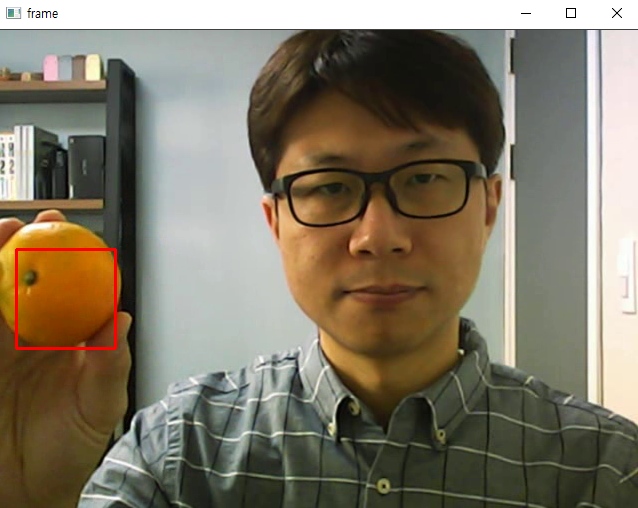

캠시프트 알고리즘  
  
캠시프트(CamShift)란?  
• Continuously Adaptive Mean Shift  
• 추적하는 객체의 크기가 변하더라도 검색 윈도우의 크기가 고정되어 있는
평균 이동 알고리즘의 단점을 보완  
  
캠시프트 동작 방법  
• 우선 평균 이동 알고리즘으로 이동 위치 계산  
• 윈도우 크기를 조정  
• 특징 공간을 가장 잘 표현하는 타원 검출  
• 새로운 크기의 윈도우를 이용하여 다시 평균 이동 수행  

캠시프트 추적 함수  
cv2.CamShift(probImage, window, criteria) -> retval, window  
  
probImage: 관심 객체에 대한 히스토그램 역투영 영상 (확률 영상)  
window: 초기 검색 영역 윈도우 & 결과 영역 반환  
criteria: 알고리즘 종료 기준. (type, maxCount, epsilon) 튜플  
=>ex> term_crit = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1) => 최대 10번 반복하며, 정확도가 1이하이면 (즉, 이동 크기가 1픽셀보다 작으면) 종료  
retval: 추적하는 객체의 모양을 나타내는 회전된 사각형 정보를 반환.
((cx, cy), (width, height), angle) 튜플  




In [11]:
import sys
import numpy as np
import cv2


# 비디오 파일 열기
cap = cv2.VideoCapture('img/camshift.avi')

if not cap.isOpened():
    print('Video open failed!')
    sys.exit()

# 초기 사각형 영역: (x, y, w, h)
x, y, w, h = 135, 220, 100, 100
rc = (x, y, w, h)

ret, frame = cap.read()

if not ret:
    print('frame read failed!')
    sys.exit()

roi = frame[y:y+h, x:x+w]
roi_hsv = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

# HS 히스토그램 계산
channels = [0, 1]
ranges = [0, 180, 0, 256]
hist = cv2.calcHist([roi_hsv], channels, None, [90, 128], ranges)

# CamShift 알고리즘 종료 기준
term_crit = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1)

# 비디오 매 프레임 처리
while True:
    ret, frame = cap.read()

    if not ret:
        break

    # HS 히스토그램에 대한 역투영
    frame_hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    backproj = cv2.calcBackProject([frame_hsv], channels, hist, ranges, 1)

    # CamShift
    ret, rc = cv2.CamShift(backproj, rc, term_crit)  # meanShift대신 CamShift를 사용함 박스의 크기달라짐

    # 추적 결과 화면 출력
    cv2.rectangle(frame, rc, (0, 0, 255), 2)
    cv2.ellipse(frame, ret, (0, 255, 0), 2)
    cv2.imshow('frame', frame)

    if cv2.waitKey(60) == 27:
        break

cap.release()
cv2.destroyAllWindows()


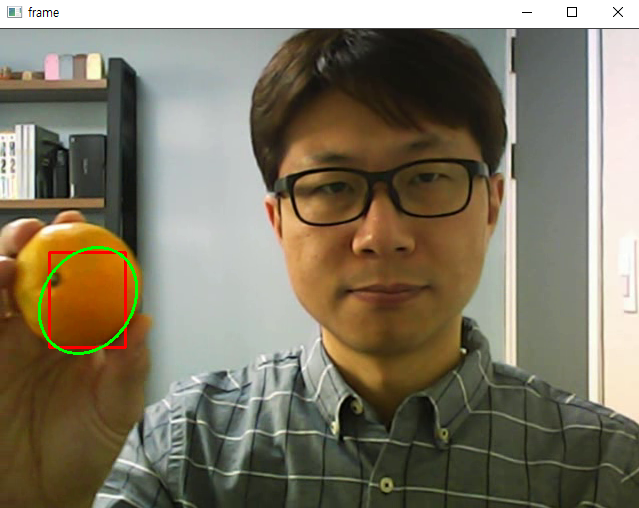

밀집 옵티컬플로우  
  
밀집 옵티컬플로우 계산 함수: 입력 영상 전체에 대해서 움직임을 계산하는 함수  
cv2.calcOpticalFlowFarneback(prev, next, flow, pyr_scale, levels, winsize, iterations, poly_n, poly_sigma, flags) -> flow  

prev, next: 이전 영상과 현재 영상. 그레이스케일 영상  
flow: (출력) 계산된 옵티컬플로우. np.ndarray. shape=(h, w, 2), dtype=np.float32  
pyr_scale: 피라미드 영상을 만들 때 축소 비율. (예) 0.5  
levels: 피라미드 영상 개수. (예) 3  
winsize: 평균 윈도우 크기. (예) 13  
iterations: 각 피라미드 레벨에서 알고리즘 반복 횟수. (예) 10  
poly_n: 다항식 확장을 위한 이웃 픽셀 크기. 보통 5 또는 7  
poly_sigma: 가우시안 표준편차. 보통 poly_n = 5이면 1.1, poly_n = 7이면 1.5  
flags: 0, cv2.OPTFLOW_USE_INITIAL_FLOW, cv2.OPTFLOW_FARNEBACK_GAUSSIAN  

In [12]:
import sys
import numpy as np
import cv2

cap = cv2.VideoCapture("img/vtest.avi")

if not cap.isOpened():
    print('Camera open failed!')
    sys.exit()

ret, frame1 = cap.read()

if not ret:
    print('frame read failed!')
    sys.exit()

gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)

hsv = np.zeros_like(frame1)#frame과 동일한 shape의 0으로 셋팅된 배열 생성
hsv[..., 1] = 255   #모든 픽셀의 1번 채널을 255로 설정, 채도를 255로 설정하는 부분이다.
# hsv[:,:,1] = hsv[..., 1] 같은 표현이다.

while True:
    ret, frame2 = cap.read()

    if not ret:
        print('frame read failed!')
        sys.exit()

    gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(gray1, gray2, None, 0.5, 3, 13, 3, 5, 1.1, 0)
    
    #좌표를 극좌표로 변환. (인풋배열1, 인풋배열2), mag : 크기, ang : 각도
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1]) 
    hsv[..., 0] = ang*180/np.pi/2  # 0은 색상
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)  # 2는 명암

    bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    cv2.imshow('frame2', frame2)
    cv2.imshow('flow', bgr)
    if cv2.waitKey(20) == 27:
        break

    gray1 = gray2

cv2.destroyAllWindows()


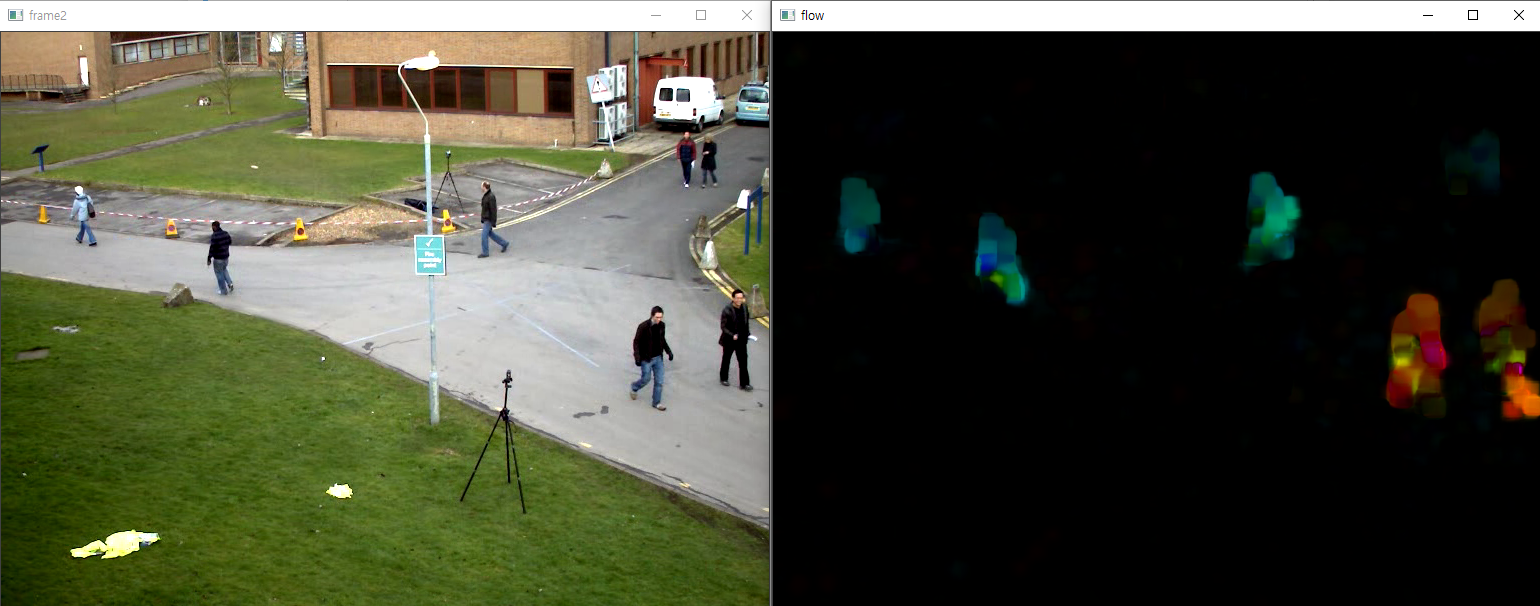

위 사진을 보면 왼쪽으로가면 초록색이고 오른쪽으로 가면 빨간색으로 나온다.

In [14]:
#pip install opencv-contrib-python
import sys
import numpy as np
import cv2


# 동영상 열기
cap = cv2.VideoCapture('img/tracking1.mp4')

if not cap.isOpened():
    print('Video open failed!')
    sys.exit()

# 트래커 객체 생성
tracker = cv2.TrackerCSRT_create()

        
# 첫 번째 프레임에서 추적 ROI 설정
ret, frame = cap.read()

if not ret:
    print('Frame read failed!')
    sys.exit()

rc = cv2.selectROI('frame', frame)
tracker.init(frame, rc)

# 매 프레임 처리
while True:
    ret, frame = cap.read()

    if not ret:
        print('Frame read failed!')
        sys.exit()

    # 추적 & ROI 사각형 업데이트
    ret, rc = tracker.update(frame)
    rc = tuple([int(_) for _ in rc])
    cv2.rectangle(frame, rc, (0, 0, 255), 2)

    cv2.imshow('frame', frame)
    if cv2.waitKey(20) == 27:
        break

cv2.destroyAllWindows()


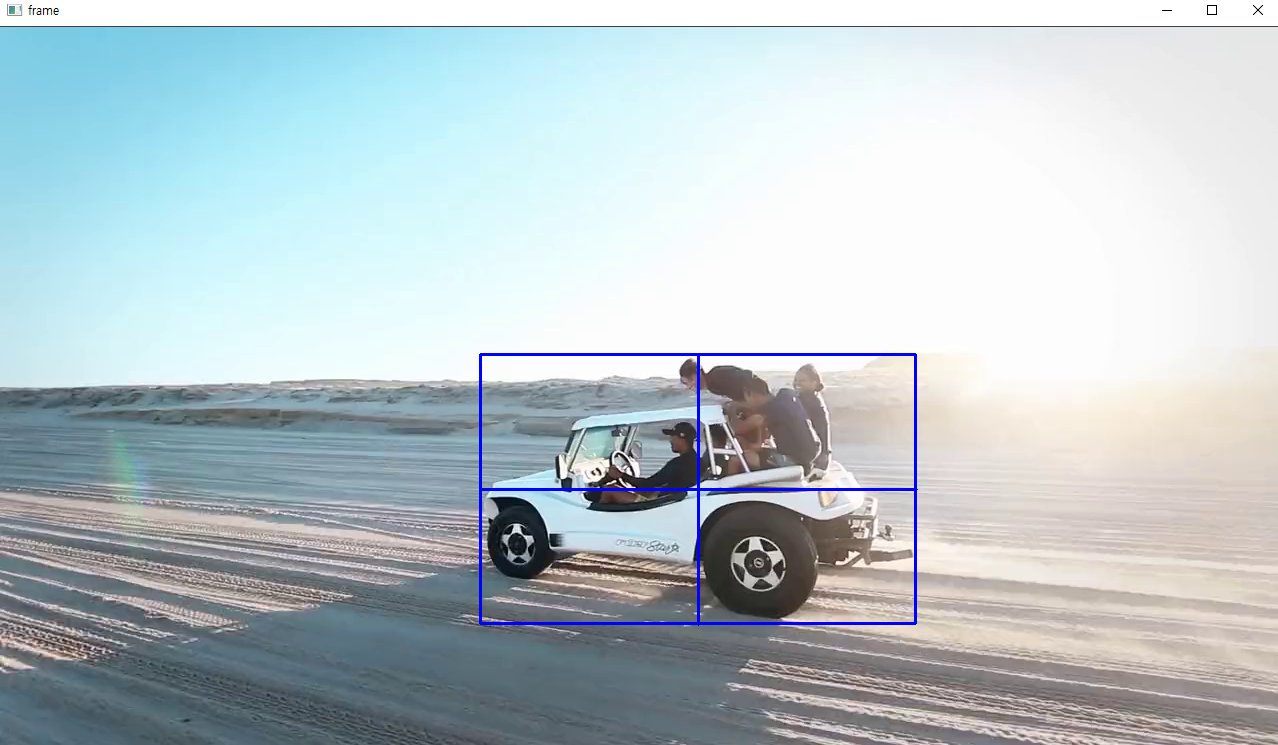

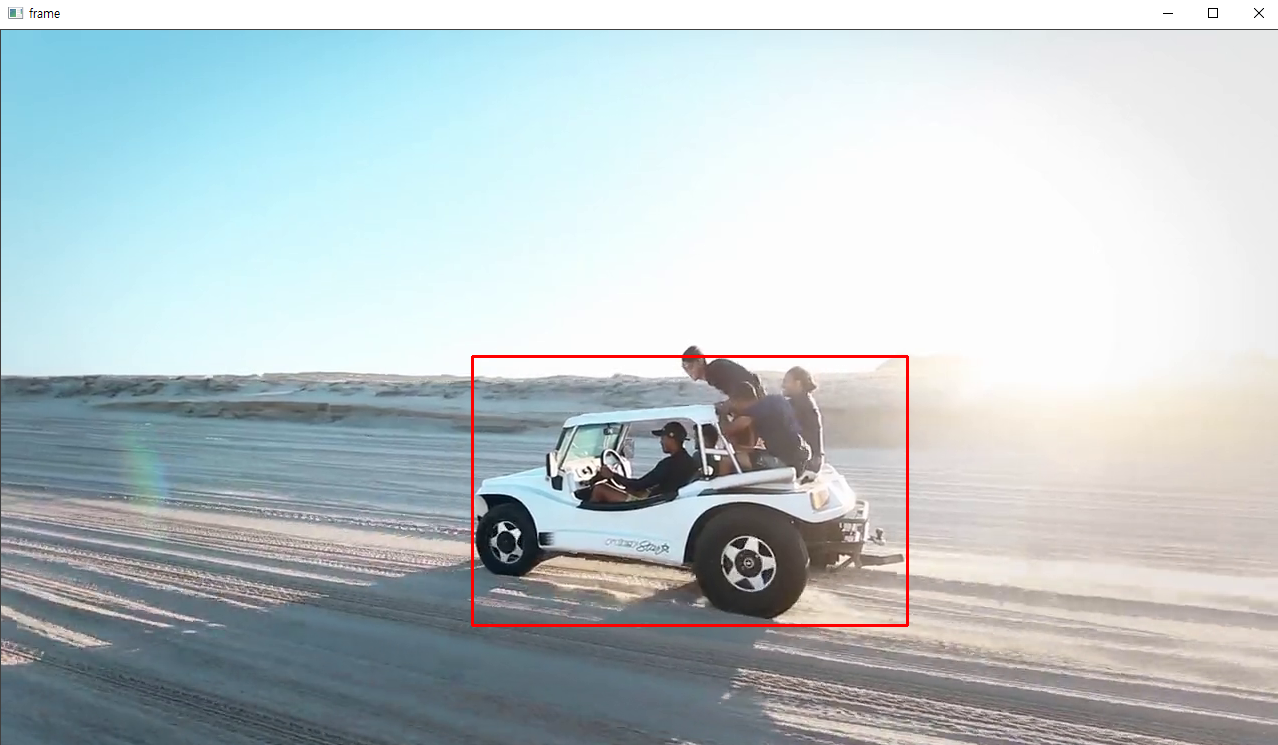